In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data
This section uses the data set berndtInvest taken
originally from R’s fEcofin package. This data set contains monthly returns
from January 1, 1978, to December 1, 1987, on 16 equities. There are 18
columns. The first column is the date and the last is the risk-free rate.


We will only use the first four equities. The following code
computes the sample covariance and correlation matrices for these returns.

In [2]:
df = pd.read_csv('./data/berndtInvest.csv')
df = df.iloc[:, 1:5]
df.head()

,CITCRP,CONED,CONTIL,DATGEN
0,-0.115,-0.079,-0.129,-0.084
1,-0.019,-0.003,0.037,-0.097
2,0.059,0.022,0.003,0.063
3,0.127,-0.005,0.180,0.179
4,0.005,-0.014,0.061,0.052


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CITCRP  120 non-null    float64
 1   CONED   120 non-null    float64
 2   CONTIL  120 non-null    float64
 3   DATGEN  120 non-null    float64
dtypes: float64(4)
memory usage: 3.9 KB


In [4]:
print("Covariance Matrix")
print(df.cov())
print("Correlation Matrix")
print(df.corr())
cov = df.cov()
cor = df.corr()

Covariance Matrix
          CITCRP     CONED    CONTIL    DATGEN
CITCRP  0.006556  0.001093  0.006052  0.005509
CONED   0.001093  0.002527  0.000795  0.000612
CONTIL  0.006052  0.000795  0.022710  0.005050
DATGEN  0.005509  0.000612  0.005050  0.016266
Correlation Matrix
          CITCRP     CONED    CONTIL    DATGEN
CITCRP  1.000000  0.268590  0.495983  0.533458
CONED   0.268590  1.000000  0.104999  0.095524
CONTIL  0.495983  0.104999  1.000000  0.262758
DATGEN  0.533458  0.095524  0.262758  1.000000


# Use the sample covariance matrix to estimate the variance of 0.5X1 + 0.3X2 + 0.2X3.

Based on the linear combination, we can write that the weight vectors as [0.5, 0.3, 0.2, 0]

In [5]:
from sklearn.covariance import MinCovDet
from scipy.stats import multivariate_t
from scipy.stats import chi2

In [6]:
w = np.array([0.5, 0.3, 0.2, 0])
var = w.T @ cov @ w
print("The variance of the portfolio is {}".format(var))

The variance of the portfolio is 0.0044088647366946785


# Find the MLE of ν and a 90 % profile likelihood confidence interval for ν.

In [7]:
dgf = np.arange(2.5, 8, 0.01)
n = len(dgf)
loglik_profile = np.zeros(n)

for i in range(n):
    fit = MinCovDet(support_fraction=1).fit(df)
    mu = fit.location_
    sigma = fit.covariance_
    rv = multivariate_t(loc=mu, shape=sigma, df=dgf[i])
    loglik_profile[i] = np.sum(np.log(rv.pdf(df)))

In [8]:
idx_mle = np.argmax(loglik_profile)
mle_nu = dgf[idx_mle]
critical_value = norm.cdf(0.95)
loglik_max = max(loglik_profile)
alpha = 0.1  # 90% confidence level
chi2_value = chi2.ppf(1 - alpha, df=1)
ci = dgf[loglik_profile >= (loglik_profile[idx_mle] - chi2_value/2)]

NameError: name 'norm' is not defined

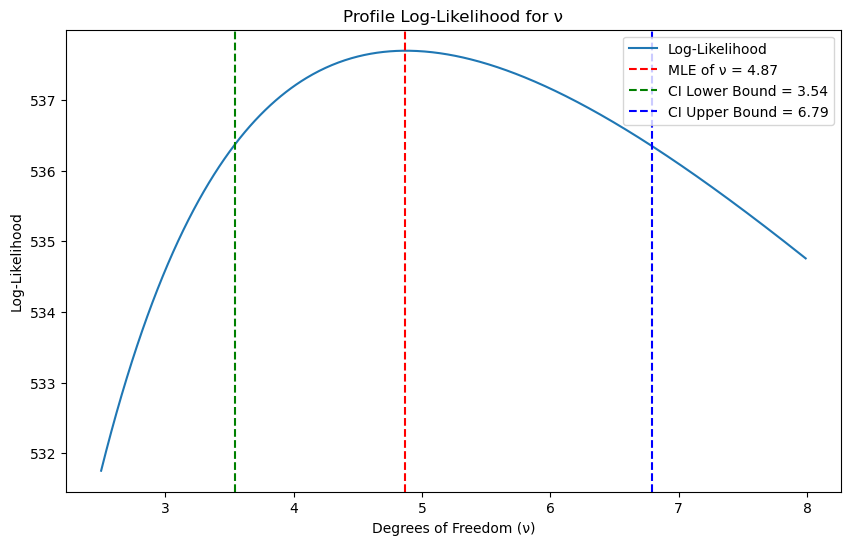

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dgf, loglik_profile, label='Log-Likelihood')
plt.axvline(x=mle_nu, color='r', linestyle='--', label=f'MLE of ν = {mle_nu:.2f}')
plt.axvline(x=ci[0], color='g', linestyle='--', label=f'CI Lower Bound = {ci[0]:.2f}')
plt.axvline(x=ci[-1], color='b', linestyle='--', label=f'CI Upper Bound = {ci[-1]:.2f}')
plt.title('Profile Log-Likelihood for ν')
plt.xlabel('Degrees of Freedom (ν)')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.show()

# Simulate multivariate t distribution

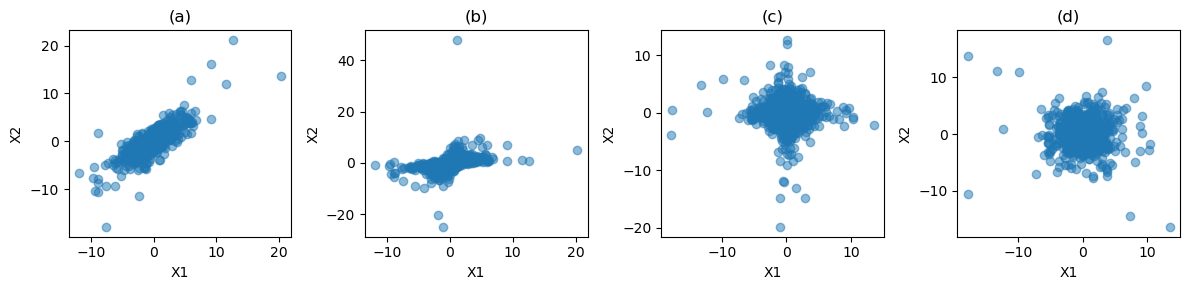

In [ ]:
def simulate_and_plot(cov, equal_weights=True, subplot_title=''):
    np.random.seed(5640)
    N = 2500
    nu = 3
    x = np.random.multivariate_normal([0, 0], cov, size=N)

    if equal_weights:
        w = np.sqrt(nu / chi2.rvs(nu, size=N))
        x *= w[:, np.newaxis]
    else:
        w1 = np.sqrt(nu / chi2.rvs(nu, size=N))
        w2 = np.sqrt(nu / chi2.rvs(nu, size=N))
        x *= np.array([w1, w2]).T

    plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
    plt.title(subplot_title)
    plt.xlabel('X1')
    plt.ylabel('X2')

# Set up the plot grid
plt.figure(figsize=(12, 3))

# Panel (a)
plt.subplot(1, 4, 1)
simulate_and_plot(cov=np.array([[1, 0.8], [0.8, 1]]), equal_weights=True, subplot_title='(a)')

# Panel (b)
plt.subplot(1, 4, 2)
simulate_and_plot(cov=np.array([[1, 0.8], [0.8, 1]]), equal_weights=False, subplot_title='(b)')

# Panel (c)
plt.subplot(1, 4, 3)
simulate_and_plot(cov=np.array([[1, 0], [0, 1]]), equal_weights=False, subplot_title='(c)')

# Panel (d)
plt.subplot(1, 4, 4)
simulate_and_plot(cov=np.array([[1, 0], [0, 1]]), equal_weights=True, subplot_title='(d)')

plt.tight_layout()
plt.show()

* Plot (a): Generated with a covariance matrix that has off-diagonal elements of 0.8, indicating a strong positive linear relationship between $x_1$ and $x_2$.

* Plot (b): The scaling variables are different from plot (a), and the variables are still exhibited some degree of linear dependency, but different from plot (a).

* Plot (c): Generated with a covariance matrix that has off-diagonal elements of 0, indicating no linear relationship between $x_1$ and $x_2$.

* Plot (d): Similar to plot (c) but with identical random weights applied to the variables, still no dependency, but higher variance.

Plot (c) likely shows the sample with independent variates, as suggested by the lack of a discernible pattern or directionality in the spread of points. The data points are roughly symmetrically distributed around the origin without a clear linear trend, which is consistent with a covariance matrix where the off-diagonal elements are 0, indicating no correlation.

Plot (b) likely show linear relationship, but no tail dependence.

Plot (c) likely show uncorrelated but with tail dependence.

Suppose that (X, Y ) are the returns on two assets and have a
multivariate t-distribution with degrees of freedom, mean vector, and covariance matrix.

$$\nu = 5$$

$$
\mu = \begin{pmatrix}
0.001 \\
0.002
\end{pmatrix},
$$

and $\Sigma$:

$$
\Sigma = \begin{pmatrix}
0.10 & 0.03 \\
0.03 & 0.15
\end{pmatrix}.
$$

If R = (X + Y) / 2, is the return on an equally weighted portfolio of the two assets.

In [ ]:
mu = np.array([0.001, 0.002])
sigma = np.array([[0.10, 0.03],
                    [0.03, 0.15]])

# Now we calculate the distribution of the portfolio

In [ ]:
# Calculate portfolio distribution
mu_r = np.mean(mu)

weight = np.array([0.5, 0.5])

var_r = weight @ sigma @ weight

print("The mean of the portfolio is {}".format(mu_r))
print("The variance of the portfolio is {}".format(var_r))

The mean of the portfolio is 0.0015
The variance of the portfolio is 0.0775


In [ ]:
from scipy.stats import t
import seaborn as sns

In [ ]:
U = np.random.uniform(0,1,10000)

In [ ]:
nu = 5
R_sim = t.ppf(U, df = nu, loc = mu_r, scale = var_r)

## Compute 99% VaR

In [ ]:
lost = -R_sim
VaR_99 = np.quantile(lost,0.99)
cVaR_99 = np.mean(lost[lost > VaR_99])
print("99% VaR for the simulated portfolio is {}".format(VaR_99))
print("The cVaR is {}".format(cVaR_99))

99% VaR for the simulated portfolio is 0.2566107653701363
The cVaR is 0.34050193146914715


#  Fitting a Bivariate t-Distribution



In [30]:
Y = pd.read_csv('./data/CRSPday.csv', index_col='rownames')
Y = Y.iloc[:,[4, 6]]
Y.head()

,ibm,crsp
rownames,,
1,0.000000,-0.007619
2,0.005128,0.013016
3,-0.002041,0.002815
4,-0.006135,0.003064
5,0.004115,0.001633


In [31]:
from scipy.stats import multivariate_t
from scipy.optimize import minimize

In [86]:
def loglik(par):
    mu = par[0:2]
    A = np.array([[par[2], 0], [par[3], par[4]]])
    scale_matrix = np.dot(A.T, A)
    df = par[5]
    return -np.sum(multivariate_t.logpdf(Y, df = df, loc = mu, shape = scale_matrix))

A = np.linalg.cholesky(np.cov(Y.T))
start = np.concatenate([np.mean(Y, axis=0), A.flatten()[[0, 2, 3]], [4]])
bounds = ((-0.02 + 1e-5, 0.02 - 1e-5), (-0.02 + 1e-5, 0.02 - 1e-5), (-0.01 + 1e-5, 0.01 - 1e-5),
            (-0.01 + 1e-5, 0.01 - 1e-5), (-0.01 + 1e-5, 0.01 - 1e-5), (2 + 1e-5, 15 - 1e-5))
result = minimize(loglik, start, method="L-BFGS-B", bounds=bounds)
if result.success:
    estimated_params = result.x
    print('Estimated parameters:', estimated_params)
else:
    print('Optimization failed:', result.message)
result

Estimated parameters: [3.93096385e-04 8.55837524e-04 9.99000000e-03 5.65803153e-03
 5.40063907e-03 3.61735983e+00]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -16095.675117822728
        x: [ 3.931e-04  8.558e-04  9.990e-03  5.658e-03  5.401e-03
             3.617e+00]
      nit: 15
      jac: [-2.923e+00  1.704e+00 -2.271e+04  1.338e+00 -8.273e-01
             7.276e-04]
     nfev: 119
     njev: 17
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

Now, we have found the MLE of theta

In [91]:
print("mu is [{}, {}]".format(estimated_params[0], estimated_params[1]))
print("Scale matrix is [[{}, {}], [{}, {}]]".format(estimated_params[2], estimated_params[3], 0, estimated_params[4]))
print("Degree of Freedom is {}".format(estimated_params[-1]))

mu is [0.0003930963849281056, 0.000855837524005319]
Scale matrix is [[0.00999, 0.005658031527305888], [0, 0.005400639073339999]]
Degree of Freedom is 3.6173598299583736


In [83]:
loglik(start)

[[0.0174966  0.        ]
 [0.00377336 0.00677887]]
[[3.20369109e-04 2.55790977e-05]
 [2.55790977e-05 4.59530351e-05]]
4.0


-15755.002170064401

In [ ]:
''